# Pixel an Image Stegnography Solution

In [344]:
from pynq import Overlay, allocate
import pynq.lib.dma
overlay = Overlay('overlay.bit')
import numpy as np
from PIL import Image
import time

## PL 

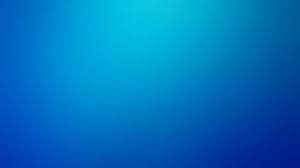

In [345]:
im = Image.open('0.png')
im

In [346]:
buf_in = allocate((im.height,im.width,3,), np.uint32, cacheable=True )
out_buffer = allocate(shape=(im.height,im.width,3,), dtype=np.uint32,  cacheable=True )

buf_in[:] = np.array(im)

dma0 = overlay.axi_dma_0
px=overlay.pixel

## Charachter word to decimal


In [347]:
def convertWordToDecimal(wordString):
    wordInDecimal = 0
    
    for character in wordString:
        wordInDecimal = wordInDecimal*100 + ord(character)
        
    return wordInDecimal

In [348]:
wordInDecimal = convertWordToDecimal("ANY")

### Embedding

In [349]:
# Embedding characters in the image - Register Map
px.register_map.in_decimal_i=wordInDecimal ## concatinating three ascii character values 50  65  89
px.register_map.position1=1         ## starting from R value of pixel 1
px.register_map.position2=24        ## ending with B value of pixel 8
px.register_map.selector = 0        ## encoding mode
px.register_map.stream_count= im.width * im.height * 3  ##size of stream

#### Embedding characters in the image - DMA

In [350]:
%%timeit
dma0.sendchannel.transfer(buf_in)
dma0.recvchannel.transfer(out_buffer)
dma0.sendchannel.wait()
dma0.recvchannel.wait()

10 loops, best of 3: 27.7 ms per loop


In [353]:
buf_in[0][0:14]

PynqBuffer([[  1,  88, 187],
            [  0,  90, 187],
            [  3,  91, 188],
            [  3,  91, 188],
            [  2,  92, 188],
            [  3,  93, 189],
            [  3,  93, 189],
            [  3,  93, 189],
            [  1,  94, 189],
            [  2,  95, 190],
            [  1,  96, 190],
            [  1,  96, 190],
            [  2,  97, 191],
            [  2,  97, 191]], dtype=uint32)

In [354]:
out_buffer[0][0:14]

PynqBuffer([[  1,  88, 186],
            [  1,  91, 186],
            [  3,  90, 188],
            [  3,  91, 189],
            [  2,  92, 189],
            [  2,  93, 188],
            [  2,  92, 188],
            [  2,  93, 188],
            [  1,  94, 189],
            [  2,  95, 190],
            [  1,  96, 190],
            [  1,  96, 190],
            [  2,  97, 191],
            [  2,  97, 191]], dtype=uint32)

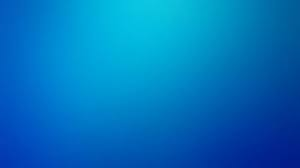

In [355]:
im_out = Image.fromarray((out_buffer).astype('uint8'))

display(im_out)

### Decryption

In [356]:
# Decrypting characters from the image - Register Map
# px.register_map.in_decimal_i=20888
px.register_map.position1=1
px.register_map.position2=24
px.register_map.selector = 1
px.register_map.stream_count= im.width * im.height * 3


###### Decrypting characters from the image - DMA

In [357]:
# %%timeit
start_time = time.time()
dma0.sendchannel.transfer(out_buffer)
dma0.recvchannel.transfer(out_buffer)
dma0.sendchannel.wait()
dma0.recvchannel.wait()
end_time = time.time()
end_time - start_time

0.033846139907836914

In [360]:
decimal_values = px.register_map.in_decimal_o
get_hidden_characters(decimal_values)

ANY

In [359]:
def get_hidden_characters(decimal_values):
    
    dec_string = ""
    num = int(decimal_values)
    for x in range(3):
        #dec_string += str(int(num)%100)
        print(chr(int(num)%100),end='')
        num = num // 100
        
    

## PS

In [361]:
def convert(n):
    binn = 0
    rem = 0
    i=1
    step = 1
    while (n != 0):
        rem = n % 2
        n //= 2
        binn += rem * i
        i *= 10
    return binn

def decrypt(data):
    global final_char
    bit=0
#     final_char=0
    if(data % 2 == 0):
        bit = 0
    elif(data % 2 != 0):
        bit=1
        
    final_char= final_char*10+bit
    
def convertBinInt(n):
    dec=0
    rem=0
    b = 0
    i = 7
    while (n != 0):
        b=pow(10,i)
        rem = n // b
        n =n % b
        dec += rem * pow(2, 7-i)
#         --i
        i -= 1
    return dec

def getDecimal(n):
    num = 0
    num = n % 100
    return num

In [363]:
final_char=0
decimalOut = 0

def pixel(in_decimal,selector,position1,position2,stream_count,buf_in_ps):
    decimalCounter = 0
    global decimalOut
    global final_char
    x = ''
    
    
    for i in range(stream_count):
        
        if not selector:
            
            if (i == 0):
                final_char=0
                decNum = in_decimal
            
            if((i >= (position1 - 1)) and (i < position2)):
                    addNum=0
                    if(decimalCounter % 8 == 0):
                        lastDecimalVal = getDecimal(decNum)
                        decNum = decNum // 100
                        charIn=convert(lastDecimalVal)
                        
                    addNum=charIn%10
                    charIn=charIn//10

                    if(buf_in_ps[i] % 2 == 0 and addNum == 1):
                        buf_in_ps[i] += 1
                    
                    elif(buf_in_ps[i] % 2 != 0 and addNum == 0):
                        buf_in_ps[i] -= 1
                    
                    decimalCounter=decimalCounter+1
                    
        elif selector:
            
            if((i >= (position1 - 1)) and (i < position2)):
                
                decrypt(buf_in_ps[i])
                decimalCounter=decimalCounter+1
                
                if(decimalCounter == 8):
                    
#                     decimalOut=decimalOut*100+convertBinInt(final_char)
                    
                    x += str(convertBinInt(final_char))
                    decimalCounter=0
                    final_char=0

            if (i == stream_count-1):
                count_streams = 0
                charIn=0
                addNum=0
                decimalCounter=0
                decimalOut = int(x)
                
            
#     if(selector == 1):
#         final_char=0
# #             in_decimal=decimalOut
#         decimalOut=0
                
    out_buffer_ps = np.copy(buf_in_ps).reshape(im.height,im.width,3)
    return out_buffer_ps


## Encrypting using PS


In [364]:
in_decimal=wordInDecimal
selector=0
position1=1
position2=24
stream_count=im.height*im.width*3
buf_in_ps=buf_in.ravel() ##turn 3d array to 1d array

In [366]:
# %%timeit
start_time = time.time()
out_buffer_ps = pixel(in_decimal,selector,position1,position2,stream_count,buf_in_ps)
end_time = time.time()
end_time - start_time

0.2581057548522949

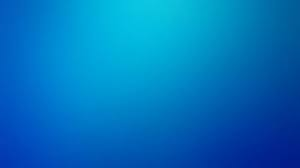

In [367]:
im_out_ps = Image.fromarray((out_buffer_ps).astype('uint8'))

display(im_out_ps)

## Decrypting using PS


In [368]:
# in_decimal=0
selector=1
position1=1
position2=24
stream_count=im.height*im.width*3
buf_in_ps=out_buffer_ps.ravel() ##turn 3d array to 1d array

In [376]:
start_time = time.time()
out_buffer_ps = pixel(in_decimal,selector,position1,position2,stream_count,buf_in_ps)
end_time = time.time()
end_time - start_time


0.353377103805542

In [370]:
get_hidden_characters(decimalOut)

ANY

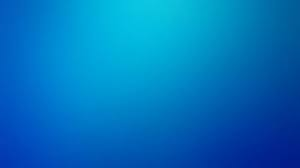

In [371]:
im_out_ps = Image.fromarray((out_buffer_ps).astype('uint8'))

display(im_out_ps)